In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Arguments 

In [65]:
corr = 0.25
seq_length = 1000

# Load Model

In [40]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_initseed4_batch512"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000400.ckpt


# Load Model

In [66]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr1e-05_drop0_initseed1_batch256"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000400.ckpt


In [67]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [68]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

# Load Dataset and Create Environment

In [69]:
n_eval_envs = -1 #50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


In [70]:
def run_model(traj, model, seq_length=1200, start_idx=800):
    hidden_states = []

    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),  # Ignored
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers of (1, seq, dim)
    state_features = batch['context_states'][0][start_idx:].to('cpu').numpy()
    next_state_features = batch['context_next_states'][0][start_idx:].to('cpu').numpy()
    actions = batch['context_actions'][0].argmax(dim=1)[start_idx:].to('cpu').numpy()
    for i_layer in range(model.n_layer):
        hidden_states.append(_hidden_states[i_layer][0,start_idx:-1])
    return hidden_states, state_features, next_state_features, actions

# Across context decoding
(within-context is not that good)

In [71]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [75]:
def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "layer": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        "maze_eighth": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'next_state_feature': [],
        "on_path": [],
        "on_lr_path": [],
        "inverse_action": []
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        hidden_states, state_features, next_state_features, actions = run_model(traj, model, seq_length, start_idx)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        seen_combos = set()
        for state_idx, state_feature in enumerate(state_features):
            next_state_feature = next_state_features[state_idx]
            state_feature_tuple = tuple(state_feature.tolist())
            next_state_feature_tuple = tuple(next_state_feature.tolist())
            action = actions[state_idx]
            combo = tuple(state_feature.tolist() + next_state_feature.tolist())
            if combo in seen_combos:
                continue
            seen_combos.add(combo)
            d = dist_from_goal[next_state_feature_tuple]
            layer = env.node_map[next_state_feature_tuple].layer
            pos = env.node_map[next_state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            if action == 0:
                if env.node_map[next_state_feature_tuple].left == env.node_map[state_feature_tuple]:
                    inverse_action = 1
                elif env.node_map[next_state_feature_tuple].right == env.node_map[state_feature_tuple]:
                    inverse_action = 2
                else:
                    inverse_action = -1
            elif action == 1 or action == 2:
                inverse_action = 0
            else:
                inverse_action = 3
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["layer"].append(layer)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["maze_eighth"].append(maze_eighth)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["next_state_feature"].append(next_state_feature)
            Ys_dict["on_path"].append(action == opt_action_map[state_feature_tuple])
            Ys_dict["on_lr_path"].append(
                (action == opt_action_map[state_feature_tuple]) and
                (action in [1, 2])
                )
            Ys_dict["inverse_action"].append(inverse_action)

            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()

    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [76]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(4, 4))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-3, 3, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()
            
            print()

    return pipelines, test_scores

In [77]:
X_train, X_test, Ys_dict = make_train_test_matrices()

Layer 0:
Best C: 0.022
Train Balanced Accuracy: 0.843
Test Balanced Accuracy: 0.772
Train Weighted F1: 0.854
Test Weighted F1: 0.812
Class distribution:
Class False: 10258 samples
Class True: 1102 samples



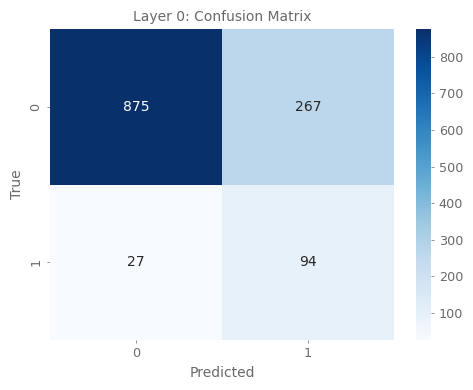


Layer 1:
Best C: 0.005
Train Balanced Accuracy: 0.949
Test Balanced Accuracy: 0.931
Train Weighted F1: 0.942
Test Weighted F1: 0.935
Class distribution:
Class False: 10258 samples
Class True: 1102 samples



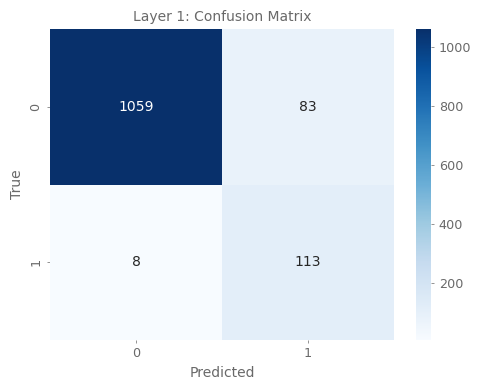

In [78]:
_Y_train = [a in [1, 2] for a in Ys_dict['opt_action']["Y_train"]]
_Y_test = [a in [1, 2] for a in Ys_dict['opt_action']["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test)

In [52]:
valid_train_idxs = np.argwhere(np.array(Ys_dict["inverse_action"]["Y_train"]) != -1).squeeze()
valid_test_idxs = np.argwhere(np.array(Ys_dict["inverse_action"]["Y_test"]) != -1).squeeze()
_X_train = [[X[i] for i in valid_train_idxs] for X in X_train]
_X_test = [[X[i] for i in valid_test_idxs] for X in X_test]
key = "inverse_action"
_Ys_dict = {'Y_train': [Ys_dict[key]["Y_train"][i] for i in valid_train_idxs], 'Y_test': [Ys_dict[key]["Y_test"][i] for i in valid_test_idxs]}
pipeline, test_score = fit_and_evaluate_classification(_X_train, _Ys_dict["Y_train"], _X_test, _Ys_dict["Y_test"])

Layer 0:
Best C: 0.022
Train Balanced Accuracy: 0.851
Test Balanced Accuracy: 0.793
Train Weighted F1: 0.894
Test Weighted F1: 0.853
Class distribution:
Class 0: 3608 samples
Class 1: 1340 samples
Class 2: 1326 samples
Class 3: 1210 samples

Layer 1:
Best C: 0.464
Train Balanced Accuracy: 0.927
Test Balanced Accuracy: 0.875
Train Weighted F1: 0.948
Test Weighted F1: 0.912
Class distribution:
Class 0: 3608 samples
Class 1: 1340 samples
Class 2: 1326 samples
Class 3: 1210 samples



Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.763
Test Balanced Accuracy: 0.706
Train Weighted F1: 0.771
Test Weighted F1: 0.722
Class distribution:
Class False: 7479 samples
Class True: 3881 samples



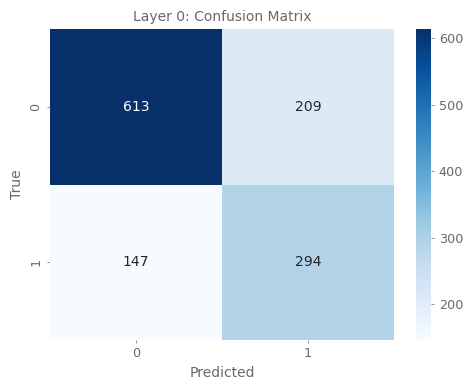


Layer 1:
Best C: 0.464
Train Balanced Accuracy: 0.856
Test Balanced Accuracy: 0.806
Train Weighted F1: 0.862
Test Weighted F1: 0.820
Class distribution:
Class False: 7479 samples
Class True: 3881 samples



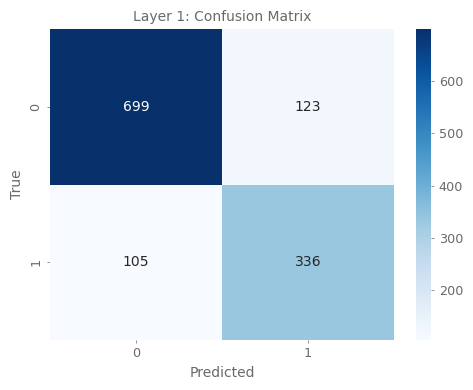

In [79]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

In [54]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_half_as_goal"]["Y_train"], X_test, Ys_dict["same_half_as_goal"]["Y_test"])

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.828
Test Balanced Accuracy: 0.800
Train Weighted F1: 0.828
Test Weighted F1: 0.801
Class distribution:
Class False: 3779 samples
Class True: 3725 samples

Layer 1:
Best C: 0.464
Train Balanced Accuracy: 0.849
Test Balanced Accuracy: 0.820
Train Weighted F1: 0.849
Test Weighted F1: 0.820
Class distribution:
Class False: 3779 samples
Class True: 3725 samples



In [80]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y <= 6 for y in Ys_dict["dist_from_goal"]["Y_train"]],
    X_test,
    [y <= 6 for y in Ys_dict["dist_from_goal"]["Y_test"]]
    )

In [56]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y <= 3 for y in Ys_dict["dist_from_goal"]["Y_train"]],
    X_test,
    [y <= 3 for y in Ys_dict["dist_from_goal"]["Y_test"]]
    )

Layer 0:
Best C: 0.022
Train Balanced Accuracy: 0.881
Test Balanced Accuracy: 0.873
Train Weighted F1: 0.886
Test Weighted F1: 0.885
Class distribution:
Class False: 7019 samples
Class True: 485 samples

Layer 1:
Best C: 0.022
Train Balanced Accuracy: 0.948
Test Balanced Accuracy: 0.916
Train Weighted F1: 0.946
Test Weighted F1: 0.943
Class distribution:
Class False: 7019 samples
Class True: 485 samples



In [34]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train,
    [y == 6 for y in Ys_dict["layer"]["Y_train"]],
    X_test,
    [y == 6 for y in Ys_dict["layer"]["Y_test"]])

Layer 0:
Best C: 0.359
Train Balanced Accuracy: 0.978
Test Balanced Accuracy: 0.960
Train Weighted F1: 0.975
Test Weighted F1: 0.956
Class distribution:
Class False: 5203 samples
Class True: 2301 samples

Layer 1:
Best C: 0.359
Train Balanced Accuracy: 0.979
Test Balanced Accuracy: 0.965
Train Weighted F1: 0.977
Test Weighted F1: 0.964
Class distribution:
Class False: 5203 samples
Class True: 2301 samples



/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 0:
Best C: 0.464
Train Balanced Accuracy: 0.699
Test Balanced Accuracy: 0.461
Train Weighted F1: 0.641
Test Weighted F1: 0.481
Class distribution:
Class 0: 94 samples
Class 1: 237 samples
Class 2: 449 samples
Class 3: 793 samples
Class 4: 1339 samples
Class 5: 2276 samples
Class 6: 2316 samples



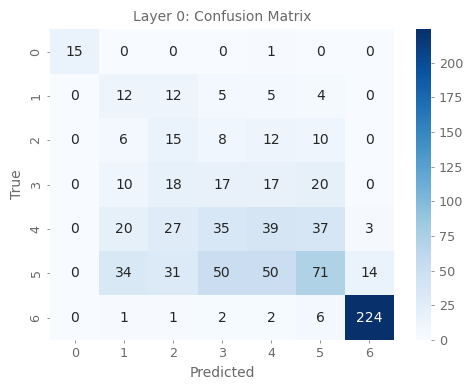


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.824
Test Balanced Accuracy: 0.665
Train Weighted F1: 0.805
Test Weighted F1: 0.699
Class distribution:
Class 0: 94 samples
Class 1: 237 samples
Class 2: 449 samples
Class 3: 793 samples
Class 4: 1339 samples
Class 5: 2276 samples
Class 6: 2316 samples



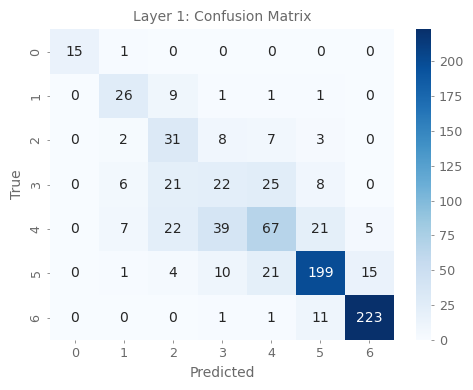

In [64]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["layer"]["Y_train"], X_test, Ys_dict["layer"]["Y_test"])

In [36]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["node_identity"]["Y_train"], X_test, Ys_dict["node_identity"]["Y_test"])

Layer 0:
Best C: 21.544
Train Balanced Accuracy: 1.000
Test Balanced Accuracy: 0.155
Train Weighted F1: 1.000
Test Weighted F1: 0.190
Class distribution:
Class 1: 99 samples
Class 2: 137 samples
Class 3: 114 samples
Class 4: 113 samples
Class 5: 115 samples
Class 6: 118 samples
Class 7: 106 samples
Class 8: 100 samples
Class 9: 98 samples
Class 10: 107 samples
Class 11: 89 samples
Class 12: 101 samples
Class 13: 110 samples
Class 14: 94 samples
Class 15: 91 samples
Class 16: 79 samples
Class 17: 85 samples
Class 18: 81 samples
Class 19: 91 samples
Class 20: 82 samples
Class 21: 93 samples
Class 22: 80 samples
Class 23: 75 samples
Class 24: 77 samples
Class 25: 86 samples
Class 26: 98 samples
Class 27: 98 samples
Class 28: 75 samples
Class 29: 80 samples
Class 30: 83 samples
Class 31: 86 samples
Class 32: 70 samples
Class 33: 57 samples
Class 34: 67 samples
Class 35: 62 samples
Class 36: 91 samples
Class 37: 65 samples
Class 38: 76 samples
Class 39: 72 samples
Class 40: 70 samples
Class

In [37]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_half"]["Y_train"], X_test, Ys_dict["maze_half"]["Y_test"])

Layer 0:
Best C: 0.046
Train Balanced Accuracy: 0.879
Test Balanced Accuracy: 0.858
Train Weighted F1: 0.820
Test Weighted F1: 0.787
Class distribution:
Class 0: 99 samples
Class 1: 3653 samples
Class 2: 3752 samples

Layer 1:
Best C: 0.359
Train Balanced Accuracy: 0.899
Test Balanced Accuracy: 0.867
Train Weighted F1: 0.851
Test Weighted F1: 0.803
Class distribution:
Class 0: 99 samples
Class 1: 3653 samples
Class 2: 3752 samples

